In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load data
bank_info = pd.read_csv('bank-additional-full.csv', delimiter=";")
bank_info.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Leaving age, duration, call_time, previous contact and euribor3m as numerical columns
age = bank_info.age
duration = bank_info.duration
call_time = bank_info.campaign
prev_contact = bank_info.previous
euribor3m = bank_info.euribor3m

In [4]:
# Rearrange the job column
j = bank_info.job
job = pd.get_dummies(j, prefix='job')
job.drop([job.columns[0]], axis=1, inplace=True)

In [5]:
# Force to stop showing warning for assigning grouped data the same categorical names
pd.options.mode.chained_assignment = None

In [6]:
# Rearrange the marital column, regroup by married and unknown
m = bank_info.marital
#m[(m == 'divorced')|(m == 'married')].loc[:]= 'married_current_or_before'
m[(m == 'divorced')|(m == 'married')] = 'married_current_or_before'
m[(m == 'single') | (m == 'unknown')] = 'not_married'
marital = pd.get_dummies(m)
marital.drop([marital.columns[0]], axis=1, inplace=True)

In [7]:
# Rearrange the education level column, regroup by high school below and above
e = bank_info.education
e[(e == 'illiterate')|(e == 'basic.4y')|(e == 'basic.6y')|(e == 'basic.9y')]= 'high_school_below'
e[(e == 'university.degree')|(e == 'professional.course')|(e == 'unknown')] = 'high_school_above'
education = pd.get_dummies(e)
education.drop([education.columns[0]], axis=1, inplace=True)

In [8]:
# Rearrange the contact communication type column
contact = pd.get_dummies(bank_info.contact)
contact.drop([contact.columns[0]], axis=1, inplace=True)

In [9]:
# Rearrange the column for number of employees - quarterly indicator
ne = bank_info['nr.employed']
ne[(ne == 4963.6)|(ne == 4991.6)|(ne == 5008.7)|(ne == 5017.5)|(ne == 5023.5)|(ne == 5076.2)] = '5099_below'
ne[(ne == 5176.3)|(ne == 5191.0)|(ne == 5195.8)|(ne == 5228.1)] = '5100_above'
number_employed = pd.get_dummies(ne)
number_employed.drop([number_employed.columns[0]], axis=1, inplace=True)

In [10]:
# Rearrange the column for last contact month of year
month = pd.get_dummies(bank_info.month)
month.drop([month.columns[0]], axis=1, inplace=True)

In [11]:
# Rearrange the column for last contact day of the week
day_of_week = pd.get_dummies(bank_info.day_of_week)
day_of_week.drop([day_of_week.columns[0]], axis=1, inplace=True)

In [12]:
# Rearrange the column for number of days that passed by after the client was last contacted from a previous campaign
p = bank_info.pdays
p[p != 999] = '0-27'
last_contact = pd.get_dummies(p)
last_contact.drop([last_contact.columns[0]], axis=1, inplace=True)

In [13]:
# Rearrange the previous outcome column
prev_outcome = pd.get_dummies(bank_info.poutcome, prefix='prev_outcome')
prev_outcome.drop([prev_outcome.columns[0]], axis=1, inplace=True)

In [14]:
# Rearrange the employment variation rate, consumer price index and consumer confidence index
emp_var_rate = pd.get_dummies(bank_info['emp.var.rate'], prefix='evr')
emp_var_rate.drop([emp_var_rate.columns[0]], axis=1, inplace=True)
cons_price_idx  = pd.get_dummies(bank_info['cons.price.idx'], prefix='cpi')
cons_price_idx.drop([cons_price_idx.columns[0]], axis=1, inplace=True)
cons_conf_idx = pd.get_dummies(bank_info['cons.conf.idx'], prefix='cci')
cons_conf_idx.drop([cons_conf_idx.columns[0]], axis=1, inplace=True)

#Tried to treat these columns as numerical values other than categories below. However, this method gives about the same result.
#emp_var_rate = bank_info['emp.var.rate']
#cons_price_idx = bank_info['cons.price.idx']
#cons_conf_idx = bank_info['cons.conf.idx']

In [15]:
# Rearrange the two loans columns
hou_loan = pd.get_dummies(bank_info.housing, prefix='hou_loan')
hou_loan.drop([hou_loan.columns[0]], axis=1, inplace=True)
per_loan = pd.get_dummies(bank_info.loan, prefix='per_loan')
per_loan.drop([per_loan.columns[0]], axis=1, inplace=True)

In [16]:
# Rearrange the default column
defa = bank_info.default
defa[defa == 'yes'] = 'unknown'
default = pd.get_dummies(defa, prefix='default')
default.drop([default.columns[0]], axis=1, inplace=True)

In [17]:
# Save the output column
output = pd.get_dummies(bank_info.y).yes
output = output.rename("y")

In [18]:
# The entire rearranged data set
data_df = pd.concat([age, job, marital, education, default, hou_loan, per_loan, contact, month, 
                  duration, call_time, day_of_week, last_contact, prev_contact, prev_outcome, 
                  emp_var_rate, number_employed, cons_price_idx, cons_conf_idx, euribor3m, output], axis=1)
pd.set_option('display.max_columns', None)
data_df.head()
data_df.shape

(41188, 103)

In [19]:
# Save the entire rearranged data set
pd.DataFrame.to_csv(data_df, path_or_buf='../capstone_project_1/rearranged_whole_data_set.csv'
                    , index=False)

In [18]:
# Rearranged data set that excluding cons.conf.idx, tue and thur in day_of week, housing loan, personal loan, dec in month, 
# unemployed, techician and unknown in job and age
day_of_week.drop(['tue','thu'], axis=1, inplace=True)
month.drop('dec', axis=1, inplace=True)
job.drop(['job_unemployed','job_technician','job_unknown'], axis=1, inplace=True)
data_df = pd.concat([job, marital, education, default, contact, month, 
                  duration, call_time, day_of_week, last_contact, prev_contact, prev_outcome, 
                  emp_var_rate, number_employed, cons_price_idx, euribor3m, output], axis=1)
pd.set_option('display.max_columns', None)
data_df.head()
data_df.shape

(41188, 35)

In [18]:
# Rearrangeed data set that excluding age, personal loan, housing loan, marital, job, 
# Jun, Nov and Aug in month and Thursday in day_of_week
day_of_week.drop('thu', axis=1, inplace=True)
month.drop(['jun', 'nov', 'aug'], axis=1, inplace=True)
data_df = pd.concat([education, default, contact, month, duration, call_time, day_of_week, last_contact, 
                    prev_contact, prev_outcome, emp_var_rate, number_employed, cons_price_idx, cons_conf_idx, 
                     euribor3m, output], axis=1)
pd.set_option('display.max_columns', None)
data_df.head()
data_df.shape

(41188, 82)

In [19]:
# Save the optimal data set for future training
pd.DataFrame.to_csv(data_df, path_or_buf='../capstone_project_1/rearranged_optimal_data_set.csv'
                   , index=False)

In [19]:
# Standardize variables

scaler = StandardScaler()
a = data_df.drop([data_df.columns[-1]], axis=1)
scaler.fit(a)
b = pd.DataFrame(scaler.transform(a))
b['y'] = data_df.iloc[:,-1]
b.columns = data_df.columns
b.head()

,age,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,not_married,high_school_above,high_school_below,default_unknown,hou_loan_unknown,hou_loan_yes,per_loan_unknown,per_loan_yes,telephone,aug,dec,jul,jun,mar,may,nov,oct,sep,duration,campaign,mon,thu,tue,wed,0-27,previous,prev_outcome_nonexistent,prev_outcome_success,evr_-3.0,evr_-2.9,evr_-1.8,evr_-1.7,evr_-1.1,evr_-0.2,evr_-0.1,evr_1.1,evr_1.4,5099_below,5100_above,cpi_92.379,cpi_92.431,cpi_92.469,cpi_92.649,cpi_92.713,cpi_92.756,cpi_92.843,cpi_92.893,cpi_92.963,cpi_93.075,cpi_93.2,cpi_93.369,cpi_93.444,cpi_93.749,cpi_93.798,cpi_93.876,cpi_93.918,cpi_93.994,cpi_94.027,cpi_94.055,cpi_94.199,cpi_94.215,cpi_94.465,cpi_94.601,cpi_94.767,cci_-50.0,cci_-49.5,cci_-47.1,cci_-46.2,cci_-45.9,cci_-42.7,cci_-42.0,cci_-41.8,cci_-40.8,cci_-40.4,cci_-40.3,cci_-40.0,cci_-39.8,cci_-38.3,cci_-37.5,cci_-36.4,cci_-36.1,cci_-34.8,cci_-34.6,cci_-33.6,cci_-33.0,cci_-31.4,cci_-30.1,cci_-29.8,cci_-26.9,euribor3m,y
0,1.533034,-0.538317,-0.19143,6.152772,-0.276435,-0.208757,-0.189032,-0.326556,-0.147327,-0.442449,-0.158872,-0.089871,-0.627943,-0.931813,1.512246,-0.513713,-0.156933,-1.048877,-0.156933,-0.422872,1.31827,-0.420076,-0.066621,-0.459253,-0.385042,-0.115907,1.411155,-0.332532,-0.133197,-0.118462,0.010471,-0.565922,1.959,-0.514581,-0.494394,-0.496067,-0.195415,-0.349494,0.397706,-0.1857,-0.064757,-0.205121,-0.53569,-0.138299,-0.125134,-0.015584,-0.313369,2.075013,-0.806571,-0.370184,0.698189,-0.080776,-0.104746,-0.065882,-0.093506,-0.064757,-0.015584,-0.083029,-0.404599,-0.132914,-0.251923,-0.310229,-0.080318,-0.379075,-0.065134,-0.040365,-0.071929,-0.440172,2.075013,-0.075427,-0.074773,-0.086087,-0.087225,-0.344693,-0.070552,-0.055834,-0.083029,-0.070552,-0.251923,-0.404599,-0.015584,-0.440172,-0.310229,-0.344693,-0.132914,-0.040365,-0.087225,-0.071929,-0.074773,-0.075427,-0.086087,2.075013,-0.379075,-0.080318,-0.065134,-0.065882,-0.064757,-0.138025,-0.093506,-0.080776,-0.104746,0.71246,0
1,1.628993,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,3.062258,-0.147327,-0.442449,-0.158872,-0.089871,-0.627943,-0.931813,-0.661268,1.946613,-0.156933,-1.048877,-0.156933,-0.422872,1.31827,-0.420076,-0.066621,-0.459253,-0.385042,-0.115907,1.411155,-0.332532,-0.133197,-0.118462,-0.421501,-0.565922,1.959,-0.514581,-0.494394,-0.496067,-0.195415,-0.349494,0.397706,-0.1857,-0.064757,-0.205121,-0.53569,-0.138299,-0.125134,-0.015584,-0.313369,2.075013,-0.806571,-0.370184,0.698189,-0.080776,-0.104746,-0.065882,-0.093506,-0.064757,-0.015584,-0.083029,-0.404599,-0.132914,-0.251923,-0.310229,-0.080318,-0.379075,-0.065134,-0.040365,-0.071929,-0.440172,2.075013,-0.075427,-0.074773,-0.086087,-0.087225,-0.344693,-0.070552,-0.055834,-0.083029,-0.070552,-0.251923,-0.404599,-0.015584,-0.440172,-0.310229,-0.344693,-0.132914,-0.040365,-0.087225,-0.071929,-0.074773,-0.075427,-0.086087,2.075013,-0.379075,-0.080318,-0.065134,-0.065882,-0.064757,-0.138025,-0.093506,-0.080776,-0.104746,0.71246,0
2,-0.290186,-0.538317,-0.19143,-0.162528,-0.276435,-0.208757,-0.189032,3.062258,-0.147327,-0.442449,-0.158872,-0.089871,-0.627943,-0.931813,-0.661268,-0.513713,-0.156933,0.953401,-0.156933,-0.422872,1.31827,-0.420076,-0.066621,-0.459253,-0.385042,-0.115907,1.411155,-0.332532,-0.133197,-0.118462,-0.124520,-0.565922,1.959,-0.514581,-0.494394,-0.496067,-0.195415,-0.349494,0.397706,-0.1857,-0.064757,-0.205121,-0.53569,-0.138299,-0.125134,-0.015584,-0.313369,2.075013,-0.806571,-0.370184,0.698189,-0.080776,-0.104746,-0.065882,-0.093506,-0.064757,-0.015584,-0.083029,-0.404599,-0.132914,-0.251923,-0.310229,-0.080318,-0.379075,-0.065134,-0.040365,-0.071929,-0.440172,2.075013,-0.075427,-0.074773,-0.086087,-0.087225,-0.344693,-0.070552,-0.055834,-0.083029,-0.070552,-0.251923,-0.404599,-0.015584,-0.440172,-0.310229,-0.344693,-0.132914,-0.040365,-0.087225,-0.071929,-0.074773,-0.075427,-0.086087,2.075013,-0.379075,-0.080318,-0.0651

In [34]:
# Splitting the data to 70% training, 20% validating and 10% testing
np.random.seed(101)
data = np.random.permutation(b)
train, validate, test = np.split(data, [int(.7*len(data)), int(.9*len(data))])

X_train = train[:, :-1]
Y_train = train[:, -1]
X_test = validate[:, :-1]
Y_test = validate[:, -1]
X_final = test[:, :-1]
Y_final = test[:, -1]

print(X_train.shape)
print(X_test.shape)
print(X_final.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_final.shape)

(28831, 102)
(8238, 102)
(4119, 102)
(28831,)
(8238,)
(4119,)


In [51]:
# Try gridsearch for tuning parameters
parameters = {'C':[0.1, 1, 10], 'tol':[1e-06, 1e-05, 0.0001]}
clf = GridSearchCV(model1, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, Y_train)
clf.best_estimator_, clf.best_params_, clf.best_score_

(LogisticRegression(C=1, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=1e-06, verbose=0, warm_start=False),
 {'C': 1, 'tol': 1e-06},
 0.86309874787555063)

In [52]:
Y_pred = clf.predict(X_test)
accuracy_score(Y_pred, Y_test)

0.86113134255887347

#### From the results it is obvious that tuning parameters does not improve the performance compared with just using the default parameters.

In [56]:
# Train the data using logistic regression
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [22]:
# Presenting sorted features based on their corresponding coefficients
features = pd.DataFrame(a.columns, columns=['features'])[:-1]
coefficients = pd.DataFrame(abs(model1.coef_)).unstack().unstack()
results = pd.concat([features, coefficients], axis=1)
results.columns = ['features', 'coefficients']
results.sort_values(by='coefficients')

,features,coefficients
10,job_unemployed,0.000347
18,per_loan_unknown,0.003508
16,hou_loan_unknown,0.003508
0,age,0.005245
11,job_unknown,0.005883
28,oct,0.007195
29,sep,0.007881
3,job_housemaid,0.010831
22,dec,0.012199
12,not_married,0.014131


In [23]:
number = np.array(range(0,8237))
number

array([   0,    1,    2, ..., 8234, 8235, 8236])

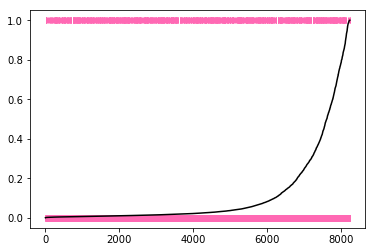

In [25]:
model1 = LogisticRegression()
model1.fit(X_train, Y_train)
probability = model1.predict_proba(X_test)[:,1]
prob_sorted = sorted(probability)
plt.plot(number, Y_test, '|', color ='hotpink')
plt.plot(number, prob_sorted, color ='black')

In [57]:
# Check the score for the model 
print(model1.score(X_test, Y_test))

0.861131342559


In [40]:
# Classification report for including all the data
print(classification_report(y_true=Y_test, y_pred=model1.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.93      0.97      0.95      7303
        yes       0.69      0.45      0.55       934

avg / total       0.90      0.91      0.91      8237



In [71]:
# Classification report for excluding features with low coefficients 
#(age, duration, nr.employed, default, housing loan, campaign, previous, marital, education)
print(classification_report(y_true=Y_test, y_pred=model1.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.91      0.99      0.95      7335
        yes       0.71      0.23      0.35       902

avg / total       0.89      0.91      0.88      8237



In [41]:
# Classification report for excluding age, personal loan, housing loan, marital, job, month and day of week
print(classification_report(y_true=Y_test, y_pred=model1.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.93      0.97      0.95      7292
        yes       0.67      0.43      0.52       945

avg / total       0.90      0.91      0.90      8237



In [25]:
# Classification report for excluding age, personal loan, housing loan, marital, job, 
#Jun, Nov and Aug in month and Thursday in day_of_week
print(classification_report(y_true=Y_test, y_pred=model1.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.94      0.97      0.95      7315
        yes       0.67      0.48      0.56       922

avg / total       0.91      0.92      0.91      8237



In [37]:
# Classification report for adding class weight in logistic regression to balance the skewed data
print(classification_report(y_true=Y_test, y_pred=model1.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.98      0.86      0.92      7280
        yes       0.45      0.88      0.60       958

avg / total       0.92      0.86      0.88      8238



In [55]:
# Classification report after tuning hyperparameters using GridSearchCV
print(classification_report(y_true=Y_test, y_pred=model1.predict(X_test), target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.98      0.86      0.92      7280
        yes       0.45      0.88      0.60       958

avg / total       0.92      0.86      0.88      8238

